# Program Description: Machine Learning Modeling (MLP - Classification)

## Overview:
- This module is responsible for building a **classification model** using a **multi-layer perceptron (MLP)** neural network. 
- The model is trained using the dataset output from **Module 9**, which contains **normalized data**.
- After training, the best model is saved, and predictions are made on the test set.

## Key Steps:

1. **Dataset Input:**
   - The feature and label datasets for training and validation are read from the output of **Module 9**.
   - These datasets are preprocessed and normalized.

2. **Model Building:**
   - A multi-layer perceptron (MLP) neural network model is constructed and trained on the data.
   - The best-performing model during training is saved for future use.

3. **Prediction and Evaluation:**
   - The trained model is used to make predictions on the validation or test dataset.
   - Model performance is evaluated using relevant classification metrics (accuracy, F1 score, etc.).

4. **Output:**
   - The trained model is saved in the `datasets-ml` folder within the current working directory.
   - Each run saves the model with a unique timestamp in the format: `MLPmodel--{current_time}`.

## Output Files:
- **Trained Model:**
  - Stored in the `datasets-ml` folder under a file name containing the timestamp.
  - Example: `MLPmodel--{current_time}.h5`.

- **Predictions:**
  - The model's predictions are saved in a separate file (e.g., `predictions.csv`) for later analysis.

## Logging and Monitoring:
- Logs are generated to track the training progress, dataset sizes, and model performance metrics.


contacts：zhaohf@ihep.ac.cn

#  Import libraries

In [1]:
import os
import sys
import pkg_resources
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import logging
from datetime import datetime
from tensorflow.keras import regularizers
import keras.callbacks
from IPython.display import Image, display
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss


2025-02-25 11:39:49.505980: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


##  Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = ['tensorflow', 'numpy', 'joblib', 'matplotlib','seaborn','sklearn']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

tensorflow: 2.9.1
numpy: 1.23.5
joblib: 1.4.0
matplotlib: 3.7.5
seaborn: 0.13.2
sklearn: 1.3.2
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter Settings (Input File, Output File)

## Input File Path:
- `dir_data`: Specifies the directory where the preprocessed dataset is located.
- The dataset includes **training**, **validation**, and **test** sets generated in **Module 9**.
- Example: `'0926-datasets/datasets(JmolNN)-pre-xmu-cn'`.

## Output File Path:
- `output_path`: The directory where the trained model will be saved.
- The model and logs will be stored under the `datasets-ml` folder in the current working path.
- Example: `'0926-datasets-ml/ml-cn-xmu-(JmolNN)'`.

## Model Output File Name:
- `dir_output`: The output save file name, which includes a timestamp (`current_time`), ensuring a unique file name for each run.
- Example: `'MLPmodel-{current_time}'` where `{current_time}` is the timestamp formatted as `YYYYMMDD_HHMM`.

## Logging Configuration:
- A log file (`training_log.txt`) will be generated to track the training progress, dataset sizes, and model details.
- The log is stored in the output directory, providing real-time updates for monitoring.

## Data Loading:
- `file_train_feature`, `file_train_label`: Specifies the file paths for training features and labels.
- `file_valid_feature`, `file_valid_label`: Specifies the file paths for validation features and labels.
- `file_test_feature`, `file_test_label`: Specifies the file paths for test features and labels.


In [3]:
# Set input file path
dir_data = '0926-datasets/datasets(JmolNN)-pre-xmu-cn'
# Set output file save path
output_path = '0926-datasets-ml/ml-cn-xmu-(JmolNN)'
current_time = datetime.now().strftime("%Y%m%d_%H%M")
# Output save file name and add timestamp
dir_output=os.path.join(output_path,f'MLPmodel-{current_time}')
# Check if the input path exists
if os.path.exists(dir_data):
    print(f"File '{dir_data}' exists.")
else:
    raise FileNotFoundError(f"File '{dir_data}' does not exist.")
os.makedirs(dir_output, exist_ok=True)
os.makedirs(dir_output, exist_ok=True)
# Load training, validation, and test datasets
file_train_feature = os.path.join(dir_data, 'xmu_train_JmolNN.txt')
file_train_label = os.path.join(dir_data, 'label_cn_train_JmolNN.txt')
file_valid_feature = os.path.join(dir_data, 'xmu_valid_JmolNN.txt')
file_valid_label = os.path.join(dir_data, 'label_cn_valid_JmolNN.txt')
file_test_feature = os.path.join(dir_data, 'xmu_test_JmolNN.txt')
file_test_label = os.path.join(dir_data, 'label_cn_test_JmolNN.txt')
log_file_path = os.path.join(dir_output, 'training_log.txt')
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_file_path), logging.StreamHandler()])
# Read data
X_train = np.loadtxt(file_train_feature)
y_train = np.loadtxt(file_train_label, dtype=float)
X_valid = np.loadtxt(file_valid_feature)
y_valid = np.loadtxt(file_valid_label, dtype=float)
X_test = np.loadtxt(file_test_feature)
y_test = np.loadtxt(file_test_label, dtype=float)
# Prepare messages for dataset sizes
train_size_message = f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}"
valid_size_message = f"Validation set size: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}"
test_size_message = f"Test set size: X_test: {X_test.shape}, y_test: {y_test.shape}"
print(train_size_message)
print(valid_size_message)
print(test_size_message)
# Log dataset sizes
logging.info(train_size_message)
logging.info(valid_size_message)
logging.info(test_size_message)
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_valid:", np.unique(y_valid))
print("Unique labels in y_test:", np.unique(y_test))
logging.info(f"Unique labels in y_train: {np.unique(y_train)}")
logging.info(f"Unique labels in y_valid: {np.unique(y_valid)}")
logging.info(f"Unique labels in y_test: {np.unique(y_test)}")

File '0926-datasets/pca-datasets(JmolNN)-pre-xmu-cn' exists.


Training set size: X_train: (3455, 1000), y_train: (3455,)
Validation set size: X_valid: (987, 1000), y_valid: (987,)
Test set size: X_test: (494, 1000), y_test: (494,)
Unique labels in y_train: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_valid: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_test: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


Training set size: X_train: (3455, 1000), y_train: (3455,)
Validation set size: X_valid: (987, 1000), y_valid: (987,)
Test set size: X_test: (494, 1000), y_test: (494,)
Unique labels in y_train: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_valid: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_test: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


# Build a MLP classification model and save the best model results

In [4]:
all_labels = np.concatenate((y_train, y_valid, y_test))
num_classes = len(np.unique(all_labels))
min_label = np.min(all_labels)
y_train = to_categorical(y_train - min_label, num_classes=num_classes)
y_valid = to_categorical(y_valid - min_label, num_classes=num_classes)
y_test = to_categorical(y_test - min_label, num_classes=num_classes)
#model.add(Dense(num_classes, activation='softmax')) 
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','mae'])
model_file = os.path.join(dir_output, 'best_model.h5')
checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        log_message = (f"Epoch {epoch + 1}, "
                       f"Loss: {logs['loss']:.4f}, "
                       f"Accuracy: {logs['accuracy']:.4f}, "
                       f"Val_Loss: {logs['val_loss']:.4f}, "
                       f"Val_Accuracy: {logs['val_accuracy']:.4f}")
        logging.info(log_message)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint, CustomCallback()])


2025-02-25 11:39:53.770209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
105/108 [============================>.] - ETA: 0s - loss: 4.3413 - accuracy: 0.3226 - mae: 0.1536
Epoch 1: val_accuracy improved from -inf to 0.45491, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 1, Loss: 4.2996, Accuracy: 0.3265, Val_Loss: 2.7861, Val_Accuracy: 0.4549


108/108 [==============================] - 2s 15ms/step - loss: 4.2996 - accuracy: 0.3265 - mae: 0.1529 - val_loss: 2.7861 - val_accuracy: 0.4549 - val_mae: 0.1359
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 2.4272 - accuracy: 0.4023 - mae: 0.1356
Epoch 2: val_accuracy improved from 0.45491 to 0.48126, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 2, Loss: 2.4272, Accuracy: 0.4023, Val_Loss: 1.9700, Val_Accuracy: 0.4813


108/108 [==============================] - 1s 11ms/step - loss: 2.4272 - accuracy: 0.4023 - mae: 0.1356 - val_loss: 1.9700 - val_accuracy: 0.4813 - val_mae: 0.1352
Epoch 3/100
103/108 [===========================>..] - ETA: 0s - loss: 1.8721 - accuracy: 0.4275 - mae: 0.1314
Epoch 3: val_accuracy improved from 0.48126 to 0.53597, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 3, Loss: 1.8661, Accuracy: 0.4292, Val_Loss: 1.5662, Val_Accuracy: 0.5360


108/108 [==============================] - 1s 11ms/step - loss: 1.8661 - accuracy: 0.4292 - mae: 0.1313 - val_loss: 1.5662 - val_accuracy: 0.5360 - val_mae: 0.1241
Epoch 4/100
105/108 [============================>.] - ETA: 0s - loss: 1.5657 - accuracy: 0.5027 - mae: 0.1204
Epoch 4: val_accuracy improved from 0.53597 to 0.61499, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 4, Loss: 1.5668, Accuracy: 0.5022, Val_Loss: 1.3393, Val_Accuracy: 0.6150


108/108 [==============================] - 1s 10ms/step - loss: 1.5668 - accuracy: 0.5022 - mae: 0.1205 - val_loss: 1.3393 - val_accuracy: 0.6150 - val_mae: 0.1079
Epoch 5/100
103/108 [===========================>..] - ETA: 0s - loss: 1.4041 - accuracy: 0.5461 - mae: 0.1096
Epoch 5: val_accuracy improved from 0.61499 to 0.63019, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 5, Loss: 1.4066, Accuracy: 0.5456, Val_Loss: 1.2563, Val_Accuracy: 0.6302


108/108 [==============================] - 1s 11ms/step - loss: 1.4066 - accuracy: 0.5456 - mae: 0.1097 - val_loss: 1.2563 - val_accuracy: 0.6302 - val_mae: 0.1056
Epoch 6/100
104/108 [===========================>..] - ETA: 0s - loss: 1.3484 - accuracy: 0.5625 - mae: 0.1082
Epoch 6: val_accuracy did not improve from 0.63019


Epoch 6, Loss: 1.3465, Accuracy: 0.5627, Val_Loss: 1.2117, Val_Accuracy: 0.6180


108/108 [==============================] - 1s 11ms/step - loss: 1.3465 - accuracy: 0.5627 - mae: 0.1082 - val_loss: 1.2117 - val_accuracy: 0.6180 - val_mae: 0.1019
Epoch 7/100
104/108 [===========================>..] - ETA: 0s - loss: 1.2810 - accuracy: 0.5739 - mae: 0.1052
Epoch 7: val_accuracy did not improve from 0.63019


Epoch 7, Loss: 1.2784, Accuracy: 0.5742, Val_Loss: 1.1547, Val_Accuracy: 0.6302


108/108 [==============================] - 1s 9ms/step - loss: 1.2784 - accuracy: 0.5742 - mae: 0.1049 - val_loss: 1.1547 - val_accuracy: 0.6302 - val_mae: 0.0961
Epoch 8/100
104/108 [===========================>..] - ETA: 0s - loss: 1.2405 - accuracy: 0.5874 - mae: 0.1030
Epoch 8: val_accuracy did not improve from 0.63019


Epoch 8, Loss: 1.2406, Accuracy: 0.5881, Val_Loss: 1.1523, Val_Accuracy: 0.6292


108/108 [==============================] - 1s 10ms/step - loss: 1.2406 - accuracy: 0.5881 - mae: 0.1032 - val_loss: 1.1523 - val_accuracy: 0.6292 - val_mae: 0.0986
Epoch 9/100
103/108 [===========================>..] - ETA: 0s - loss: 1.2370 - accuracy: 0.5795 - mae: 0.1035
Epoch 9: val_accuracy did not improve from 0.63019


Epoch 9, Loss: 1.2351, Accuracy: 0.5800, Val_Loss: 1.1161, Val_Accuracy: 0.6292


108/108 [==============================] - 1s 10ms/step - loss: 1.2351 - accuracy: 0.5800 - mae: 0.1032 - val_loss: 1.1161 - val_accuracy: 0.6292 - val_mae: 0.0962
Epoch 10/100
105/108 [============================>.] - ETA: 0s - loss: 1.1788 - accuracy: 0.6071 - mae: 0.0996
Epoch 10: val_accuracy did not improve from 0.63019


Epoch 10, Loss: 1.1777, Accuracy: 0.6075, Val_Loss: 1.1080, Val_Accuracy: 0.6150


108/108 [==============================] - 1s 10ms/step - loss: 1.1777 - accuracy: 0.6075 - mae: 0.0995 - val_loss: 1.1080 - val_accuracy: 0.6150 - val_mae: 0.0959
Epoch 11/100
108/108 [==============================] - ETA: 0s - loss: 1.1520 - accuracy: 0.6061 - mae: 0.0981
Epoch 11: val_accuracy did not improve from 0.63019


Epoch 11, Loss: 1.1520, Accuracy: 0.6061, Val_Loss: 1.0961, Val_Accuracy: 0.6150


108/108 [==============================] - 1s 10ms/step - loss: 1.1520 - accuracy: 0.6061 - mae: 0.0981 - val_loss: 1.0961 - val_accuracy: 0.6150 - val_mae: 0.0945
Epoch 12/100
107/108 [============================>.] - ETA: 0s - loss: 1.1259 - accuracy: 0.6180 - mae: 0.0974
Epoch 12: val_accuracy improved from 0.63019 to 0.64336, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 12, Loss: 1.1265, Accuracy: 0.6171, Val_Loss: 1.0332, Val_Accuracy: 0.6434


108/108 [==============================] - 1s 10ms/step - loss: 1.1265 - accuracy: 0.6171 - mae: 0.0974 - val_loss: 1.0332 - val_accuracy: 0.6434 - val_mae: 0.0904
Epoch 13/100
108/108 [==============================] - ETA: 0s - loss: 1.1245 - accuracy: 0.6093 - mae: 0.0981
Epoch 13: val_accuracy improved from 0.64336 to 0.64843, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 13, Loss: 1.1245, Accuracy: 0.6093, Val_Loss: 1.0422, Val_Accuracy: 0.6484


108/108 [==============================] - 1s 11ms/step - loss: 1.1245 - accuracy: 0.6093 - mae: 0.0981 - val_loss: 1.0422 - val_accuracy: 0.6484 - val_mae: 0.0945
Epoch 14/100
103/108 [===========================>..] - ETA: 0s - loss: 1.1053 - accuracy: 0.6226 - mae: 0.0961
Epoch 14: val_accuracy improved from 0.64843 to 0.65552, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 14, Loss: 1.1031, Accuracy: 0.6226, Val_Loss: 1.0060, Val_Accuracy: 0.6555


108/108 [==============================] - 1s 11ms/step - loss: 1.1031 - accuracy: 0.6226 - mae: 0.0960 - val_loss: 1.0060 - val_accuracy: 0.6555 - val_mae: 0.0898
Epoch 15/100
106/108 [============================>.] - ETA: 0s - loss: 1.0641 - accuracy: 0.6383 - mae: 0.0937
Epoch 15: val_accuracy did not improve from 0.65552


Epoch 15, Loss: 1.0679, Accuracy: 0.6356, Val_Loss: 0.9859, Val_Accuracy: 0.6545


108/108 [==============================] - 1s 9ms/step - loss: 1.0679 - accuracy: 0.6356 - mae: 0.0940 - val_loss: 0.9859 - val_accuracy: 0.6545 - val_mae: 0.0877
Epoch 16/100
108/108 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.6443 - mae: 0.0919
Epoch 16: val_accuracy improved from 0.65552 to 0.65856, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 16, Loss: 1.0542, Accuracy: 0.6443, Val_Loss: 0.9964, Val_Accuracy: 0.6586


108/108 [==============================] - 1s 11ms/step - loss: 1.0542 - accuracy: 0.6443 - mae: 0.0919 - val_loss: 0.9964 - val_accuracy: 0.6586 - val_mae: 0.0915
Epoch 17/100
108/108 [==============================] - ETA: 0s - loss: 1.0531 - accuracy: 0.6394 - mae: 0.0921
Epoch 17: val_accuracy improved from 0.65856 to 0.66768, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 17, Loss: 1.0531, Accuracy: 0.6394, Val_Loss: 0.9715, Val_Accuracy: 0.6677


108/108 [==============================] - 1s 11ms/step - loss: 1.0531 - accuracy: 0.6394 - mae: 0.0921 - val_loss: 0.9715 - val_accuracy: 0.6677 - val_mae: 0.0914
Epoch 18/100
108/108 [==============================] - ETA: 0s - loss: 1.0308 - accuracy: 0.6417 - mae: 0.0915
Epoch 18: val_accuracy did not improve from 0.66768


Epoch 18, Loss: 1.0308, Accuracy: 0.6417, Val_Loss: 0.9849, Val_Accuracy: 0.6646


108/108 [==============================] - 1s 10ms/step - loss: 1.0308 - accuracy: 0.6417 - mae: 0.0915 - val_loss: 0.9849 - val_accuracy: 0.6646 - val_mae: 0.0890
Epoch 19/100
103/108 [===========================>..] - ETA: 0s - loss: 1.0298 - accuracy: 0.6453 - mae: 0.0915
Epoch 19: val_accuracy did not improve from 0.66768


Epoch 19, Loss: 1.0278, Accuracy: 0.6489, Val_Loss: 0.9733, Val_Accuracy: 0.6616


108/108 [==============================] - 1s 11ms/step - loss: 1.0278 - accuracy: 0.6489 - mae: 0.0912 - val_loss: 0.9733 - val_accuracy: 0.6616 - val_mae: 0.0845
Epoch 20/100
105/108 [============================>.] - ETA: 0s - loss: 1.0240 - accuracy: 0.6351 - mae: 0.0911
Epoch 20: val_accuracy improved from 0.66768 to 0.68490, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 20, Loss: 1.0223, Accuracy: 0.6350, Val_Loss: 0.9334, Val_Accuracy: 0.6849


108/108 [==============================] - 1s 11ms/step - loss: 1.0223 - accuracy: 0.6350 - mae: 0.0910 - val_loss: 0.9334 - val_accuracy: 0.6849 - val_mae: 0.0873
Epoch 21/100
105/108 [============================>.] - ETA: 0s - loss: 1.0007 - accuracy: 0.6583 - mae: 0.0892
Epoch 21: val_accuracy did not improve from 0.68490


Epoch 21, Loss: 1.0040, Accuracy: 0.6564, Val_Loss: 0.9889, Val_Accuracy: 0.6667


108/108 [==============================] - 1s 10ms/step - loss: 1.0040 - accuracy: 0.6564 - mae: 0.0895 - val_loss: 0.9889 - val_accuracy: 0.6667 - val_mae: 0.0919
Epoch 22/100
103/108 [===========================>..] - ETA: 0s - loss: 1.0007 - accuracy: 0.6529 - mae: 0.0900
Epoch 22: val_accuracy did not improve from 0.68490


Epoch 22, Loss: 0.9981, Accuracy: 0.6559, Val_Loss: 0.9167, Val_Accuracy: 0.6717


108/108 [==============================] - 1s 10ms/step - loss: 0.9981 - accuracy: 0.6559 - mae: 0.0899 - val_loss: 0.9167 - val_accuracy: 0.6717 - val_mae: 0.0850
Epoch 23/100
102/108 [===========================>..] - ETA: 0s - loss: 0.9960 - accuracy: 0.6618 - mae: 0.0891
Epoch 23: val_accuracy did not improve from 0.68490


Epoch 23, Loss: 0.9880, Accuracy: 0.6654, Val_Loss: 0.9761, Val_Accuracy: 0.6667


108/108 [==============================] - 1s 10ms/step - loss: 0.9880 - accuracy: 0.6654 - mae: 0.0885 - val_loss: 0.9761 - val_accuracy: 0.6667 - val_mae: 0.0856
Epoch 24/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9861 - accuracy: 0.6596 - mae: 0.0892
Epoch 24: val_accuracy did not improve from 0.68490


Epoch 24, Loss: 0.9815, Accuracy: 0.6608, Val_Loss: 0.9057, Val_Accuracy: 0.6819


108/108 [==============================] - 1s 11ms/step - loss: 0.9815 - accuracy: 0.6608 - mae: 0.0889 - val_loss: 0.9057 - val_accuracy: 0.6819 - val_mae: 0.0854
Epoch 25/100
105/108 [============================>.] - ETA: 0s - loss: 0.9592 - accuracy: 0.6554 - mae: 0.0876
Epoch 25: val_accuracy did not improve from 0.68490


Epoch 25, Loss: 0.9628, Accuracy: 0.6530, Val_Loss: 0.9316, Val_Accuracy: 0.6788


108/108 [==============================] - 1s 10ms/step - loss: 0.9628 - accuracy: 0.6530 - mae: 0.0881 - val_loss: 0.9316 - val_accuracy: 0.6788 - val_mae: 0.0890
Epoch 26/100
107/108 [============================>.] - ETA: 0s - loss: 0.9972 - accuracy: 0.6492 - mae: 0.0897
Epoch 26: val_accuracy did not improve from 0.68490


Epoch 26, Loss: 0.9959, Accuracy: 0.6492, Val_Loss: 0.9367, Val_Accuracy: 0.6738


108/108 [==============================] - 1s 11ms/step - loss: 0.9959 - accuracy: 0.6492 - mae: 0.0896 - val_loss: 0.9367 - val_accuracy: 0.6738 - val_mae: 0.0870
Epoch 27/100
104/108 [===========================>..] - ETA: 0s - loss: 0.9680 - accuracy: 0.6593 - mae: 0.0886
Epoch 27: val_accuracy did not improve from 0.68490


Epoch 27, Loss: 0.9690, Accuracy: 0.6582, Val_Loss: 0.9029, Val_Accuracy: 0.6758


108/108 [==============================] - 1s 10ms/step - loss: 0.9690 - accuracy: 0.6582 - mae: 0.0885 - val_loss: 0.9029 - val_accuracy: 0.6758 - val_mae: 0.0854
Epoch 28/100
106/108 [============================>.] - ETA: 0s - loss: 0.9683 - accuracy: 0.6421 - mae: 0.0894
Epoch 28: val_accuracy did not improve from 0.68490


Epoch 28, Loss: 0.9656, Accuracy: 0.6446, Val_Loss: 0.9187, Val_Accuracy: 0.6798


108/108 [==============================] - 1s 10ms/step - loss: 0.9656 - accuracy: 0.6446 - mae: 0.0892 - val_loss: 0.9187 - val_accuracy: 0.6798 - val_mae: 0.0842
Epoch 29/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9625 - accuracy: 0.6559 - mae: 0.0877
Epoch 29: val_accuracy improved from 0.68490 to 0.68592, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 29, Loss: 0.9602, Accuracy: 0.6562, Val_Loss: 0.8956, Val_Accuracy: 0.6859


108/108 [==============================] - 1s 11ms/step - loss: 0.9602 - accuracy: 0.6562 - mae: 0.0875 - val_loss: 0.8956 - val_accuracy: 0.6859 - val_mae: 0.0854
Epoch 30/100
105/108 [============================>.] - ETA: 0s - loss: 0.9370 - accuracy: 0.6765 - mae: 0.0860
Epoch 30: val_accuracy did not improve from 0.68592


Epoch 30, Loss: 0.9344, Accuracy: 0.6781, Val_Loss: 0.9190, Val_Accuracy: 0.6626


108/108 [==============================] - 1s 10ms/step - loss: 0.9344 - accuracy: 0.6781 - mae: 0.0860 - val_loss: 0.9190 - val_accuracy: 0.6626 - val_mae: 0.0847
Epoch 31/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9383 - accuracy: 0.6675 - mae: 0.0855
Epoch 31: val_accuracy did not improve from 0.68592


Epoch 31, Loss: 0.9412, Accuracy: 0.6671, Val_Loss: 0.8967, Val_Accuracy: 0.6788


108/108 [==============================] - 1s 11ms/step - loss: 0.9412 - accuracy: 0.6671 - mae: 0.0856 - val_loss: 0.8967 - val_accuracy: 0.6788 - val_mae: 0.0841
Epoch 32/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9355 - accuracy: 0.6602 - mae: 0.0864
Epoch 32: val_accuracy did not improve from 0.68592


Epoch 32, Loss: 0.9414, Accuracy: 0.6573, Val_Loss: 0.9522, Val_Accuracy: 0.6707


108/108 [==============================] - 1s 10ms/step - loss: 0.9414 - accuracy: 0.6573 - mae: 0.0867 - val_loss: 0.9522 - val_accuracy: 0.6707 - val_mae: 0.0859
Epoch 33/100
105/108 [============================>.] - ETA: 0s - loss: 0.9222 - accuracy: 0.6711 - mae: 0.0850
Epoch 33: val_accuracy did not improve from 0.68592


Epoch 33, Loss: 0.9265, Accuracy: 0.6703, Val_Loss: 0.9265, Val_Accuracy: 0.6575


108/108 [==============================] - 1s 10ms/step - loss: 0.9265 - accuracy: 0.6703 - mae: 0.0852 - val_loss: 0.9265 - val_accuracy: 0.6575 - val_mae: 0.0855
Epoch 34/100
107/108 [============================>.] - ETA: 0s - loss: 0.9439 - accuracy: 0.6600 - mae: 0.0864
Epoch 34: val_accuracy did not improve from 0.68592


Epoch 34, Loss: 0.9421, Accuracy: 0.6614, Val_Loss: 0.9089, Val_Accuracy: 0.6778


108/108 [==============================] - 1s 11ms/step - loss: 0.9421 - accuracy: 0.6614 - mae: 0.0863 - val_loss: 0.9089 - val_accuracy: 0.6778 - val_mae: 0.0831
Epoch 35/100
102/108 [===========================>..] - ETA: 0s - loss: 0.9281 - accuracy: 0.6722 - mae: 0.0855
Epoch 35: val_accuracy improved from 0.68592 to 0.68997, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 35, Loss: 0.9276, Accuracy: 0.6721, Val_Loss: 0.8947, Val_Accuracy: 0.6900


108/108 [==============================] - 1s 11ms/step - loss: 0.9276 - accuracy: 0.6721 - mae: 0.0855 - val_loss: 0.8947 - val_accuracy: 0.6900 - val_mae: 0.0816
Epoch 36/100
104/108 [===========================>..] - ETA: 0s - loss: 0.9165 - accuracy: 0.6764 - mae: 0.0847
Epoch 36: val_accuracy did not improve from 0.68997


Epoch 36, Loss: 0.9167, Accuracy: 0.6755, Val_Loss: 0.8707, Val_Accuracy: 0.6859


108/108 [==============================] - 1s 10ms/step - loss: 0.9167 - accuracy: 0.6755 - mae: 0.0848 - val_loss: 0.8707 - val_accuracy: 0.6859 - val_mae: 0.0817
Epoch 37/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9325 - accuracy: 0.6687 - mae: 0.0857
Epoch 37: val_accuracy improved from 0.68997 to 0.69605, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 37, Loss: 0.9321, Accuracy: 0.6689, Val_Loss: 0.8753, Val_Accuracy: 0.6960


108/108 [==============================] - 1s 11ms/step - loss: 0.9321 - accuracy: 0.6689 - mae: 0.0857 - val_loss: 0.8753 - val_accuracy: 0.6960 - val_mae: 0.0803
Epoch 38/100
107/108 [============================>.] - ETA: 0s - loss: 0.9265 - accuracy: 0.6764 - mae: 0.0853
Epoch 38: val_accuracy did not improve from 0.69605


Epoch 38, Loss: 0.9267, Accuracy: 0.6761, Val_Loss: 0.8880, Val_Accuracy: 0.6798


108/108 [==============================] - 1s 10ms/step - loss: 0.9267 - accuracy: 0.6761 - mae: 0.0854 - val_loss: 0.8880 - val_accuracy: 0.6798 - val_mae: 0.0838
Epoch 39/100
105/108 [============================>.] - ETA: 0s - loss: 0.9159 - accuracy: 0.6705 - mae: 0.0846
Epoch 39: val_accuracy did not improve from 0.69605


Epoch 39, Loss: 0.9151, Accuracy: 0.6718, Val_Loss: 0.8658, Val_Accuracy: 0.6910


108/108 [==============================] - 1s 10ms/step - loss: 0.9151 - accuracy: 0.6718 - mae: 0.0846 - val_loss: 0.8658 - val_accuracy: 0.6910 - val_mae: 0.0785
Epoch 40/100
105/108 [============================>.] - ETA: 0s - loss: 0.9101 - accuracy: 0.6768 - mae: 0.0837
Epoch 40: val_accuracy did not improve from 0.69605


Epoch 40, Loss: 0.9110, Accuracy: 0.6764, Val_Loss: 0.8814, Val_Accuracy: 0.6910


108/108 [==============================] - 1s 10ms/step - loss: 0.9110 - accuracy: 0.6764 - mae: 0.0839 - val_loss: 0.8814 - val_accuracy: 0.6910 - val_mae: 0.0828
Epoch 41/100
104/108 [===========================>..] - ETA: 0s - loss: 0.9052 - accuracy: 0.6776 - mae: 0.0838
Epoch 41: val_accuracy did not improve from 0.69605


Epoch 41, Loss: 0.9084, Accuracy: 0.6758, Val_Loss: 0.9038, Val_Accuracy: 0.6910


108/108 [==============================] - 1s 11ms/step - loss: 0.9084 - accuracy: 0.6758 - mae: 0.0840 - val_loss: 0.9038 - val_accuracy: 0.6910 - val_mae: 0.0804
Epoch 42/100
108/108 [==============================] - ETA: 0s - loss: 0.9227 - accuracy: 0.6648 - mae: 0.0852
Epoch 42: val_accuracy did not improve from 0.69605


Epoch 42, Loss: 0.9227, Accuracy: 0.6648, Val_Loss: 0.8743, Val_Accuracy: 0.6849


108/108 [==============================] - 1s 10ms/step - loss: 0.9227 - accuracy: 0.6648 - mae: 0.0852 - val_loss: 0.8743 - val_accuracy: 0.6849 - val_mae: 0.0816
Epoch 43/100
107/108 [============================>.] - ETA: 0s - loss: 0.9020 - accuracy: 0.6752 - mae: 0.0839
Epoch 43: val_accuracy did not improve from 0.69605


Epoch 43, Loss: 0.9026, Accuracy: 0.6744, Val_Loss: 0.8571, Val_Accuracy: 0.6890


108/108 [==============================] - 1s 10ms/step - loss: 0.9026 - accuracy: 0.6744 - mae: 0.0839 - val_loss: 0.8571 - val_accuracy: 0.6890 - val_mae: 0.0796
Epoch 44/100
108/108 [==============================] - ETA: 0s - loss: 0.9069 - accuracy: 0.6787 - mae: 0.0834
Epoch 44: val_accuracy did not improve from 0.69605


Epoch 44, Loss: 0.9069, Accuracy: 0.6787, Val_Loss: 0.8563, Val_Accuracy: 0.6819


108/108 [==============================] - 1s 10ms/step - loss: 0.9069 - accuracy: 0.6787 - mae: 0.0834 - val_loss: 0.8563 - val_accuracy: 0.6819 - val_mae: 0.0809
Epoch 45/100
106/108 [============================>.] - ETA: 0s - loss: 0.8917 - accuracy: 0.6848 - mae: 0.0828
Epoch 45: val_accuracy did not improve from 0.69605


Epoch 45, Loss: 0.8888, Accuracy: 0.6857, Val_Loss: 0.8656, Val_Accuracy: 0.6798


108/108 [==============================] - 1s 10ms/step - loss: 0.8888 - accuracy: 0.6857 - mae: 0.0826 - val_loss: 0.8656 - val_accuracy: 0.6798 - val_mae: 0.0808
Epoch 46/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8931 - accuracy: 0.6806 - mae: 0.0832
Epoch 46: val_accuracy did not improve from 0.69605


Epoch 46, Loss: 0.8922, Accuracy: 0.6813, Val_Loss: 0.8864, Val_Accuracy: 0.6819


108/108 [==============================] - 1s 10ms/step - loss: 0.8922 - accuracy: 0.6813 - mae: 0.0831 - val_loss: 0.8864 - val_accuracy: 0.6819 - val_mae: 0.0801
Epoch 47/100
105/108 [============================>.] - ETA: 0s - loss: 0.9018 - accuracy: 0.6753 - mae: 0.0834
Epoch 47: val_accuracy improved from 0.69605 to 0.70314, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 47, Loss: 0.9012, Accuracy: 0.6761, Val_Loss: 0.8464, Val_Accuracy: 0.7031


108/108 [==============================] - 1s 11ms/step - loss: 0.9012 - accuracy: 0.6761 - mae: 0.0834 - val_loss: 0.8464 - val_accuracy: 0.7031 - val_mae: 0.0794
Epoch 48/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8994 - accuracy: 0.6811 - mae: 0.0832
Epoch 48: val_accuracy did not improve from 0.70314


Epoch 48, Loss: 0.8990, Accuracy: 0.6813, Val_Loss: 0.8639, Val_Accuracy: 0.6950


108/108 [==============================] - 1s 11ms/step - loss: 0.8990 - accuracy: 0.6813 - mae: 0.0831 - val_loss: 0.8639 - val_accuracy: 0.6950 - val_mae: 0.0827
Epoch 49/100
105/108 [============================>.] - ETA: 0s - loss: 0.8936 - accuracy: 0.6753 - mae: 0.0840
Epoch 49: val_accuracy did not improve from 0.70314


Epoch 49, Loss: 0.8945, Accuracy: 0.6738, Val_Loss: 0.8711, Val_Accuracy: 0.6930


108/108 [==============================] - 1s 10ms/step - loss: 0.8945 - accuracy: 0.6738 - mae: 0.0840 - val_loss: 0.8711 - val_accuracy: 0.6930 - val_mae: 0.0813
Epoch 50/100
106/108 [============================>.] - ETA: 0s - loss: 0.8905 - accuracy: 0.6807 - mae: 0.0826
Epoch 50: val_accuracy did not improve from 0.70314


Epoch 50, Loss: 0.8896, Accuracy: 0.6813, Val_Loss: 0.8665, Val_Accuracy: 0.6859


108/108 [==============================] - 1s 10ms/step - loss: 0.8896 - accuracy: 0.6813 - mae: 0.0826 - val_loss: 0.8665 - val_accuracy: 0.6859 - val_mae: 0.0828
Epoch 51/100
108/108 [==============================] - ETA: 0s - loss: 0.8869 - accuracy: 0.6828 - mae: 0.0824
Epoch 51: val_accuracy did not improve from 0.70314


Epoch 51, Loss: 0.8869, Accuracy: 0.6828, Val_Loss: 0.8678, Val_Accuracy: 0.6819


108/108 [==============================] - 1s 10ms/step - loss: 0.8869 - accuracy: 0.6828 - mae: 0.0824 - val_loss: 0.8678 - val_accuracy: 0.6819 - val_mae: 0.0785
Epoch 52/100
105/108 [============================>.] - ETA: 0s - loss: 0.8967 - accuracy: 0.6815 - mae: 0.0829
Epoch 52: val_accuracy did not improve from 0.70314


Epoch 52, Loss: 0.8969, Accuracy: 0.6805, Val_Loss: 0.8919, Val_Accuracy: 0.6687


108/108 [==============================] - 1s 10ms/step - loss: 0.8969 - accuracy: 0.6805 - mae: 0.0830 - val_loss: 0.8919 - val_accuracy: 0.6687 - val_mae: 0.0810
Epoch 53/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9044 - accuracy: 0.6823 - mae: 0.0836
Epoch 53: val_accuracy did not improve from 0.70314


Epoch 53, Loss: 0.9009, Accuracy: 0.6822, Val_Loss: 0.9097, Val_Accuracy: 0.6606


108/108 [==============================] - 1s 10ms/step - loss: 0.9009 - accuracy: 0.6822 - mae: 0.0835 - val_loss: 0.9097 - val_accuracy: 0.6606 - val_mae: 0.0819
Epoch 54/100
103/108 [===========================>..] - ETA: 0s - loss: 0.9096 - accuracy: 0.6820 - mae: 0.0844
Epoch 54: val_accuracy did not improve from 0.70314


Epoch 54, Loss: 0.9055, Accuracy: 0.6842, Val_Loss: 0.8602, Val_Accuracy: 0.6839


108/108 [==============================] - 1s 11ms/step - loss: 0.9055 - accuracy: 0.6842 - mae: 0.0839 - val_loss: 0.8602 - val_accuracy: 0.6839 - val_mae: 0.0791
Epoch 55/100
105/108 [============================>.] - ETA: 0s - loss: 0.8842 - accuracy: 0.6911 - mae: 0.0820
Epoch 55: val_accuracy did not improve from 0.70314


Epoch 55, Loss: 0.8782, Accuracy: 0.6935, Val_Loss: 0.8763, Val_Accuracy: 0.6829


108/108 [==============================] - 1s 10ms/step - loss: 0.8782 - accuracy: 0.6935 - mae: 0.0816 - val_loss: 0.8763 - val_accuracy: 0.6829 - val_mae: 0.0815
Epoch 56/100
108/108 [==============================] - ETA: 0s - loss: 0.8862 - accuracy: 0.6802 - mae: 0.0825
Epoch 56: val_accuracy did not improve from 0.70314


Epoch 56, Loss: 0.8862, Accuracy: 0.6802, Val_Loss: 0.8480, Val_Accuracy: 0.6950


108/108 [==============================] - 1s 11ms/step - loss: 0.8862 - accuracy: 0.6802 - mae: 0.0825 - val_loss: 0.8480 - val_accuracy: 0.6950 - val_mae: 0.0793
Epoch 57/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8818 - accuracy: 0.6809 - mae: 0.0816
Epoch 57: val_accuracy did not improve from 0.70314


Epoch 57, Loss: 0.8818, Accuracy: 0.6805, Val_Loss: 0.8814, Val_Accuracy: 0.6829


108/108 [==============================] - 1s 10ms/step - loss: 0.8818 - accuracy: 0.6805 - mae: 0.0817 - val_loss: 0.8814 - val_accuracy: 0.6829 - val_mae: 0.0813
Epoch 58/100
107/108 [============================>.] - ETA: 0s - loss: 0.8957 - accuracy: 0.6814 - mae: 0.0834
Epoch 58: val_accuracy did not improve from 0.70314


Epoch 58, Loss: 0.8950, Accuracy: 0.6813, Val_Loss: 0.8443, Val_Accuracy: 0.6940


108/108 [==============================] - 1s 11ms/step - loss: 0.8950 - accuracy: 0.6813 - mae: 0.0833 - val_loss: 0.8443 - val_accuracy: 0.6940 - val_mae: 0.0798
Epoch 59/100
102/108 [===========================>..] - ETA: 0s - loss: 0.8668 - accuracy: 0.6921 - mae: 0.0810
Epoch 59: val_accuracy did not improve from 0.70314


Epoch 59, Loss: 0.8742, Accuracy: 0.6894, Val_Loss: 0.8877, Val_Accuracy: 0.6950


108/108 [==============================] - 1s 10ms/step - loss: 0.8742 - accuracy: 0.6894 - mae: 0.0816 - val_loss: 0.8877 - val_accuracy: 0.6950 - val_mae: 0.0800
Epoch 60/100
105/108 [============================>.] - ETA: 0s - loss: 0.9032 - accuracy: 0.6818 - mae: 0.0840
Epoch 60: val_accuracy did not improve from 0.70314


Epoch 60, Loss: 0.9034, Accuracy: 0.6810, Val_Loss: 0.8548, Val_Accuracy: 0.6920


108/108 [==============================] - 1s 10ms/step - loss: 0.9034 - accuracy: 0.6810 - mae: 0.0841 - val_loss: 0.8548 - val_accuracy: 0.6920 - val_mae: 0.0797
Epoch 61/100
108/108 [==============================] - ETA: 0s - loss: 0.8821 - accuracy: 0.6810 - mae: 0.0824
Epoch 61: val_accuracy did not improve from 0.70314


Epoch 61, Loss: 0.8821, Accuracy: 0.6810, Val_Loss: 0.8755, Val_Accuracy: 0.6910


108/108 [==============================] - 1s 10ms/step - loss: 0.8821 - accuracy: 0.6810 - mae: 0.0824 - val_loss: 0.8755 - val_accuracy: 0.6910 - val_mae: 0.0824
Epoch 62/100
101/108 [===========================>..] - ETA: 0s - loss: 0.8836 - accuracy: 0.6897 - mae: 0.0825
Epoch 62: val_accuracy did not improve from 0.70314


Epoch 62, Loss: 0.8829, Accuracy: 0.6912, Val_Loss: 0.8623, Val_Accuracy: 0.6971


108/108 [==============================] - 1s 9ms/step - loss: 0.8829 - accuracy: 0.6912 - mae: 0.0821 - val_loss: 0.8623 - val_accuracy: 0.6971 - val_mae: 0.0788
Epoch 63/100
105/108 [============================>.] - ETA: 0s - loss: 0.8835 - accuracy: 0.6872 - mae: 0.0818
Epoch 63: val_accuracy did not improve from 0.70314


Epoch 63, Loss: 0.8862, Accuracy: 0.6857, Val_Loss: 0.8977, Val_Accuracy: 0.6596


108/108 [==============================] - 1s 10ms/step - loss: 0.8862 - accuracy: 0.6857 - mae: 0.0820 - val_loss: 0.8977 - val_accuracy: 0.6596 - val_mae: 0.0819
Epoch 64/100
107/108 [============================>.] - ETA: 0s - loss: 0.8849 - accuracy: 0.6808 - mae: 0.0826
Epoch 64: val_accuracy did not improve from 0.70314


Epoch 64, Loss: 0.8828, Accuracy: 0.6816, Val_Loss: 0.8388, Val_Accuracy: 0.6981


108/108 [==============================] - 1s 10ms/step - loss: 0.8828 - accuracy: 0.6816 - mae: 0.0824 - val_loss: 0.8388 - val_accuracy: 0.6981 - val_mae: 0.0785
Epoch 65/100
105/108 [============================>.] - ETA: 0s - loss: 0.8726 - accuracy: 0.6899 - mae: 0.0807
Epoch 65: val_accuracy did not improve from 0.70314


Epoch 65, Loss: 0.8743, Accuracy: 0.6880, Val_Loss: 0.8396, Val_Accuracy: 0.6981


108/108 [==============================] - 1s 10ms/step - loss: 0.8743 - accuracy: 0.6880 - mae: 0.0809 - val_loss: 0.8396 - val_accuracy: 0.6981 - val_mae: 0.0795
Epoch 66/100
107/108 [============================>.] - ETA: 0s - loss: 0.8895 - accuracy: 0.6784 - mae: 0.0840
Epoch 66: val_accuracy did not improve from 0.70314


Epoch 66, Loss: 0.8904, Accuracy: 0.6779, Val_Loss: 0.9170, Val_Accuracy: 0.6667


108/108 [==============================] - 1s 10ms/step - loss: 0.8904 - accuracy: 0.6779 - mae: 0.0840 - val_loss: 0.9170 - val_accuracy: 0.6667 - val_mae: 0.0825
Epoch 67/100
105/108 [============================>.] - ETA: 0s - loss: 0.8734 - accuracy: 0.6923 - mae: 0.0809
Epoch 67: val_accuracy did not improve from 0.70314


Epoch 67, Loss: 0.8762, Accuracy: 0.6918, Val_Loss: 0.8346, Val_Accuracy: 0.6839


108/108 [==============================] - 1s 10ms/step - loss: 0.8762 - accuracy: 0.6918 - mae: 0.0810 - val_loss: 0.8346 - val_accuracy: 0.6839 - val_mae: 0.0803
Epoch 68/100
106/108 [============================>.] - ETA: 0s - loss: 0.8716 - accuracy: 0.6896 - mae: 0.0819
Epoch 68: val_accuracy did not improve from 0.70314


Epoch 68, Loss: 0.8712, Accuracy: 0.6903, Val_Loss: 0.8559, Val_Accuracy: 0.7021


108/108 [==============================] - 1s 10ms/step - loss: 0.8712 - accuracy: 0.6903 - mae: 0.0819 - val_loss: 0.8559 - val_accuracy: 0.7021 - val_mae: 0.0779
Epoch 69/100
108/108 [==============================] - ETA: 0s - loss: 0.8796 - accuracy: 0.6874 - mae: 0.0812
Epoch 69: val_accuracy improved from 0.70314 to 0.71125, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/best_model.h5


Epoch 69, Loss: 0.8796, Accuracy: 0.6874, Val_Loss: 0.8220, Val_Accuracy: 0.7112


108/108 [==============================] - 1s 11ms/step - loss: 0.8796 - accuracy: 0.6874 - mae: 0.0812 - val_loss: 0.8220 - val_accuracy: 0.7112 - val_mae: 0.0773
Epoch 70/100
106/108 [============================>.] - ETA: 0s - loss: 0.8577 - accuracy: 0.6949 - mae: 0.0806
Epoch 70: val_accuracy did not improve from 0.71125


Epoch 70, Loss: 0.8576, Accuracy: 0.6955, Val_Loss: 0.8393, Val_Accuracy: 0.7062


108/108 [==============================] - 1s 10ms/step - loss: 0.8576 - accuracy: 0.6955 - mae: 0.0806 - val_loss: 0.8393 - val_accuracy: 0.7062 - val_mae: 0.0779
Epoch 71/100
107/108 [============================>.] - ETA: 0s - loss: 0.8618 - accuracy: 0.6928 - mae: 0.0804
Epoch 71: val_accuracy did not improve from 0.71125


Epoch 71, Loss: 0.8622, Accuracy: 0.6932, Val_Loss: 0.8513, Val_Accuracy: 0.7082


108/108 [==============================] - 1s 11ms/step - loss: 0.8622 - accuracy: 0.6932 - mae: 0.0805 - val_loss: 0.8513 - val_accuracy: 0.7082 - val_mae: 0.0797
Epoch 72/100
108/108 [==============================] - ETA: 0s - loss: 0.8738 - accuracy: 0.6802 - mae: 0.0815
Epoch 72: val_accuracy did not improve from 0.71125


Epoch 72, Loss: 0.8738, Accuracy: 0.6802, Val_Loss: 0.8542, Val_Accuracy: 0.7072


108/108 [==============================] - 1s 10ms/step - loss: 0.8738 - accuracy: 0.6802 - mae: 0.0815 - val_loss: 0.8542 - val_accuracy: 0.7072 - val_mae: 0.0782
Epoch 73/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8746 - accuracy: 0.6914 - mae: 0.0809
Epoch 73: val_accuracy did not improve from 0.71125


Epoch 73, Loss: 0.8745, Accuracy: 0.6903, Val_Loss: 0.8394, Val_Accuracy: 0.7042


108/108 [==============================] - 1s 11ms/step - loss: 0.8745 - accuracy: 0.6903 - mae: 0.0810 - val_loss: 0.8394 - val_accuracy: 0.7042 - val_mae: 0.0811
Epoch 74/100
108/108 [==============================] - ETA: 0s - loss: 0.8619 - accuracy: 0.6996 - mae: 0.0802
Epoch 74: val_accuracy did not improve from 0.71125


Epoch 74, Loss: 0.8619, Accuracy: 0.6996, Val_Loss: 0.8432, Val_Accuracy: 0.7001


108/108 [==============================] - 1s 10ms/step - loss: 0.8619 - accuracy: 0.6996 - mae: 0.0802 - val_loss: 0.8432 - val_accuracy: 0.7001 - val_mae: 0.0786
Epoch 75/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8786 - accuracy: 0.7019 - mae: 0.0810
Epoch 75: val_accuracy did not improve from 0.71125


Epoch 75, Loss: 0.8779, Accuracy: 0.7036, Val_Loss: 0.8472, Val_Accuracy: 0.6960


108/108 [==============================] - 1s 10ms/step - loss: 0.8779 - accuracy: 0.7036 - mae: 0.0809 - val_loss: 0.8472 - val_accuracy: 0.6960 - val_mae: 0.0806
Epoch 76/100
105/108 [============================>.] - ETA: 0s - loss: 0.8549 - accuracy: 0.6923 - mae: 0.0799
Epoch 76: val_accuracy did not improve from 0.71125


Epoch 76, Loss: 0.8562, Accuracy: 0.6912, Val_Loss: 0.8504, Val_Accuracy: 0.7052


108/108 [==============================] - 1s 11ms/step - loss: 0.8562 - accuracy: 0.6912 - mae: 0.0801 - val_loss: 0.8504 - val_accuracy: 0.7052 - val_mae: 0.0773
Epoch 77/100
108/108 [==============================] - ETA: 0s - loss: 0.8702 - accuracy: 0.6906 - mae: 0.0818
Epoch 77: val_accuracy did not improve from 0.71125


Epoch 77, Loss: 0.8702, Accuracy: 0.6906, Val_Loss: 0.8551, Val_Accuracy: 0.6991


108/108 [==============================] - 1s 10ms/step - loss: 0.8702 - accuracy: 0.6906 - mae: 0.0818 - val_loss: 0.8551 - val_accuracy: 0.6991 - val_mae: 0.0800
Epoch 78/100
102/108 [===========================>..] - ETA: 0s - loss: 0.8615 - accuracy: 0.7031 - mae: 0.0802
Epoch 78: val_accuracy did not improve from 0.71125


Epoch 78, Loss: 0.8642, Accuracy: 0.7022, Val_Loss: 0.8475, Val_Accuracy: 0.7062


108/108 [==============================] - 1s 10ms/step - loss: 0.8642 - accuracy: 0.7022 - mae: 0.0803 - val_loss: 0.8475 - val_accuracy: 0.7062 - val_mae: 0.0776
Epoch 79/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8650 - accuracy: 0.6872 - mae: 0.0809
Epoch 79: val_accuracy did not improve from 0.71125


Epoch 79, Loss: 0.8664, Accuracy: 0.6863, Val_Loss: 0.8550, Val_Accuracy: 0.6981


108/108 [==============================] - 1s 11ms/step - loss: 0.8664 - accuracy: 0.6863 - mae: 0.0811 - val_loss: 0.8550 - val_accuracy: 0.6981 - val_mae: 0.0816
Epoch 80/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8661 - accuracy: 0.6945 - mae: 0.0810
Epoch 80: val_accuracy did not improve from 0.71125


Epoch 80, Loss: 0.8684, Accuracy: 0.6926, Val_Loss: 0.8847, Val_Accuracy: 0.6727


108/108 [==============================] - 1s 9ms/step - loss: 0.8684 - accuracy: 0.6926 - mae: 0.0811 - val_loss: 0.8847 - val_accuracy: 0.6727 - val_mae: 0.0797
Epoch 81/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8570 - accuracy: 0.6993 - mae: 0.0802
Epoch 81: val_accuracy did not improve from 0.71125


Epoch 81, Loss: 0.8554, Accuracy: 0.7001, Val_Loss: 0.8648, Val_Accuracy: 0.6960


108/108 [==============================] - 1s 11ms/step - loss: 0.8554 - accuracy: 0.7001 - mae: 0.0801 - val_loss: 0.8648 - val_accuracy: 0.6960 - val_mae: 0.0800
Epoch 82/100
107/108 [============================>.] - ETA: 0s - loss: 0.8503 - accuracy: 0.6837 - mae: 0.0800
Epoch 82: val_accuracy did not improve from 0.71125


Epoch 82, Loss: 0.8495, Accuracy: 0.6839, Val_Loss: 0.8858, Val_Accuracy: 0.6707


108/108 [==============================] - 1s 10ms/step - loss: 0.8495 - accuracy: 0.6839 - mae: 0.0800 - val_loss: 0.8858 - val_accuracy: 0.6707 - val_mae: 0.0804
Epoch 83/100
107/108 [============================>.] - ETA: 0s - loss: 0.8676 - accuracy: 0.6893 - mae: 0.0810
Epoch 83: val_accuracy did not improve from 0.71125


Epoch 83, Loss: 0.8655, Accuracy: 0.6900, Val_Loss: 0.8333, Val_Accuracy: 0.7042


108/108 [==============================] - 1s 10ms/step - loss: 0.8655 - accuracy: 0.6900 - mae: 0.0808 - val_loss: 0.8333 - val_accuracy: 0.7042 - val_mae: 0.0769
Epoch 84/100
107/108 [============================>.] - ETA: 0s - loss: 0.8560 - accuracy: 0.6980 - mae: 0.0797
Epoch 84: val_accuracy did not improve from 0.71125


Epoch 84, Loss: 0.8576, Accuracy: 0.6981, Val_Loss: 0.8474, Val_Accuracy: 0.6809


108/108 [==============================] - 1s 11ms/step - loss: 0.8576 - accuracy: 0.6981 - mae: 0.0798 - val_loss: 0.8474 - val_accuracy: 0.6809 - val_mae: 0.0790
Epoch 85/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8606 - accuracy: 0.6972 - mae: 0.0808
Epoch 85: val_accuracy did not improve from 0.71125


Epoch 85, Loss: 0.8567, Accuracy: 0.6981, Val_Loss: 0.8778, Val_Accuracy: 0.6930


108/108 [==============================] - 1s 10ms/step - loss: 0.8567 - accuracy: 0.6981 - mae: 0.0804 - val_loss: 0.8778 - val_accuracy: 0.6930 - val_mae: 0.0773
Epoch 86/100
107/108 [============================>.] - ETA: 0s - loss: 0.8611 - accuracy: 0.6922 - mae: 0.0803
Epoch 86: val_accuracy did not improve from 0.71125


Epoch 86, Loss: 0.8623, Accuracy: 0.6920, Val_Loss: 0.8316, Val_Accuracy: 0.6991


108/108 [==============================] - 1s 11ms/step - loss: 0.8623 - accuracy: 0.6920 - mae: 0.0803 - val_loss: 0.8316 - val_accuracy: 0.6991 - val_mae: 0.0784
Epoch 87/100
105/108 [============================>.] - ETA: 0s - loss: 0.8487 - accuracy: 0.6899 - mae: 0.0798
Epoch 87: val_accuracy did not improve from 0.71125


Epoch 87, Loss: 0.8469, Accuracy: 0.6909, Val_Loss: 0.8475, Val_Accuracy: 0.7031


108/108 [==============================] - 1s 10ms/step - loss: 0.8469 - accuracy: 0.6909 - mae: 0.0797 - val_loss: 0.8475 - val_accuracy: 0.7031 - val_mae: 0.0786
Epoch 88/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8466 - accuracy: 0.7039 - mae: 0.0786
Epoch 88: val_accuracy did not improve from 0.71125


Epoch 88, Loss: 0.8494, Accuracy: 0.7030, Val_Loss: 0.8535, Val_Accuracy: 0.6798


108/108 [==============================] - 1s 10ms/step - loss: 0.8494 - accuracy: 0.7030 - mae: 0.0788 - val_loss: 0.8535 - val_accuracy: 0.6798 - val_mae: 0.0804
Epoch 89/100
107/108 [============================>.] - ETA: 0s - loss: 0.8860 - accuracy: 0.6846 - mae: 0.0815
Epoch 89: val_accuracy did not improve from 0.71125


Epoch 89, Loss: 0.8873, Accuracy: 0.6842, Val_Loss: 0.8585, Val_Accuracy: 0.6971


108/108 [==============================] - 1s 11ms/step - loss: 0.8873 - accuracy: 0.6842 - mae: 0.0816 - val_loss: 0.8585 - val_accuracy: 0.6971 - val_mae: 0.0828
Epoch 90/100
108/108 [==============================] - ETA: 0s - loss: 0.8650 - accuracy: 0.6923 - mae: 0.0815
Epoch 90: val_accuracy did not improve from 0.71125


Epoch 90, Loss: 0.8650, Accuracy: 0.6923, Val_Loss: 0.8843, Val_Accuracy: 0.6890


108/108 [==============================] - 1s 10ms/step - loss: 0.8650 - accuracy: 0.6923 - mae: 0.0815 - val_loss: 0.8843 - val_accuracy: 0.6890 - val_mae: 0.0796
Epoch 91/100
106/108 [============================>.] - ETA: 0s - loss: 0.8617 - accuracy: 0.6946 - mae: 0.0801
Epoch 91: val_accuracy did not improve from 0.71125


Epoch 91, Loss: 0.8661, Accuracy: 0.6923, Val_Loss: 0.8453, Val_Accuracy: 0.6981


108/108 [==============================] - 1s 10ms/step - loss: 0.8661 - accuracy: 0.6923 - mae: 0.0803 - val_loss: 0.8453 - val_accuracy: 0.6981 - val_mae: 0.0802
Epoch 92/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8575 - accuracy: 0.7001 - mae: 0.0802
Epoch 92: val_accuracy did not improve from 0.71125


Epoch 92, Loss: 0.8581, Accuracy: 0.6981, Val_Loss: 0.8578, Val_Accuracy: 0.6940


108/108 [==============================] - 1s 10ms/step - loss: 0.8581 - accuracy: 0.6981 - mae: 0.0803 - val_loss: 0.8578 - val_accuracy: 0.6940 - val_mae: 0.0788
Epoch 93/100
107/108 [============================>.] - ETA: 0s - loss: 0.8552 - accuracy: 0.6942 - mae: 0.0806
Epoch 93: val_accuracy did not improve from 0.71125


Epoch 93, Loss: 0.8564, Accuracy: 0.6929, Val_Loss: 0.8613, Val_Accuracy: 0.6940


108/108 [==============================] - 1s 10ms/step - loss: 0.8564 - accuracy: 0.6929 - mae: 0.0807 - val_loss: 0.8613 - val_accuracy: 0.6940 - val_mae: 0.0810
Epoch 94/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8567 - accuracy: 0.6926 - mae: 0.0800
Epoch 94: val_accuracy did not improve from 0.71125


Epoch 94, Loss: 0.8550, Accuracy: 0.6923, Val_Loss: 0.8368, Val_Accuracy: 0.7062


108/108 [==============================] - 1s 10ms/step - loss: 0.8550 - accuracy: 0.6923 - mae: 0.0799 - val_loss: 0.8368 - val_accuracy: 0.7062 - val_mae: 0.0781
Epoch 95/100
103/108 [===========================>..] - ETA: 0s - loss: 0.8498 - accuracy: 0.6930 - mae: 0.0793
Epoch 95: val_accuracy did not improve from 0.71125


Epoch 95, Loss: 0.8519, Accuracy: 0.6944, Val_Loss: 0.8512, Val_Accuracy: 0.7031


108/108 [==============================] - 1s 9ms/step - loss: 0.8519 - accuracy: 0.6944 - mae: 0.0795 - val_loss: 0.8512 - val_accuracy: 0.7031 - val_mae: 0.0776
Epoch 96/100
106/108 [============================>.] - ETA: 0s - loss: 0.8618 - accuracy: 0.6925 - mae: 0.0801
Epoch 96: val_accuracy did not improve from 0.71125


Epoch 96, Loss: 0.8628, Accuracy: 0.6915, Val_Loss: 0.8439, Val_Accuracy: 0.6981


108/108 [==============================] - 1s 10ms/step - loss: 0.8628 - accuracy: 0.6915 - mae: 0.0802 - val_loss: 0.8439 - val_accuracy: 0.6981 - val_mae: 0.0774
Epoch 97/100
107/108 [============================>.] - ETA: 0s - loss: 0.8612 - accuracy: 0.6954 - mae: 0.0800
Epoch 97: val_accuracy did not improve from 0.71125


Epoch 97, Loss: 0.8602, Accuracy: 0.6955, Val_Loss: 0.8404, Val_Accuracy: 0.7092


108/108 [==============================] - 1s 10ms/step - loss: 0.8602 - accuracy: 0.6955 - mae: 0.0800 - val_loss: 0.8404 - val_accuracy: 0.7092 - val_mae: 0.0806
Epoch 98/100
105/108 [============================>.] - ETA: 0s - loss: 0.8456 - accuracy: 0.7077 - mae: 0.0797
Epoch 98: val_accuracy did not improve from 0.71125


Epoch 98, Loss: 0.8454, Accuracy: 0.7062, Val_Loss: 0.8116, Val_Accuracy: 0.6960


108/108 [==============================] - 1s 10ms/step - loss: 0.8454 - accuracy: 0.7062 - mae: 0.0797 - val_loss: 0.8116 - val_accuracy: 0.6960 - val_mae: 0.0776
Epoch 99/100
104/108 [===========================>..] - ETA: 0s - loss: 0.8685 - accuracy: 0.6890 - mae: 0.0803
Epoch 99: val_accuracy did not improve from 0.71125


Epoch 99, Loss: 0.8683, Accuracy: 0.6894, Val_Loss: 0.8398, Val_Accuracy: 0.6910


108/108 [==============================] - 1s 10ms/step - loss: 0.8683 - accuracy: 0.6894 - mae: 0.0803 - val_loss: 0.8398 - val_accuracy: 0.6910 - val_mae: 0.0779
Epoch 100/100
105/108 [============================>.] - ETA: 0s - loss: 0.8592 - accuracy: 0.6935 - mae: 0.0804
Epoch 100: val_accuracy did not improve from 0.71125


Epoch 100, Loss: 0.8627, Accuracy: 0.6926, Val_Loss: 0.8401, Val_Accuracy: 0.6890


108/108 [==============================] - 1s 10ms/step - loss: 0.8627 - accuracy: 0.6926 - mae: 0.0805 - val_loss: 0.8401 - val_accuracy: 0.6890 - val_mae: 0.0773


Model structure saved to: 0926-datasets-ml/ml-cn-xmu-(JmolNN)/pca-MLPmodel-20250225_1139/model_structure.png


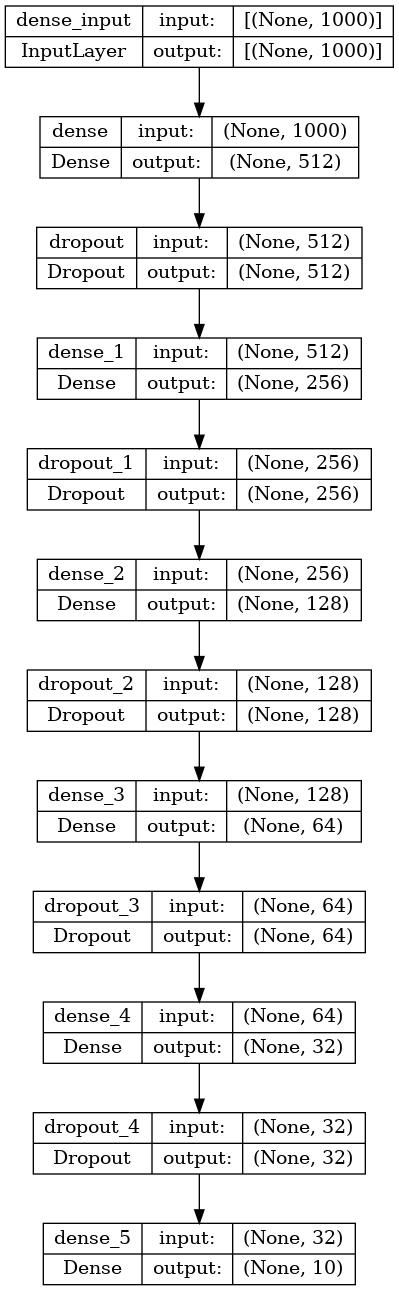

In [5]:
# Plot and save the model structure
model_structure_file = os.path.join(dir_output, 'model_structure.png')
plot_model(model, to_file=model_structure_file, show_shapes=True, show_layer_names=True)
print(f"Model structure saved to: {model_structure_file}")
display(Image(filename=model_structure_file))

# Plot the loss curve of the training process

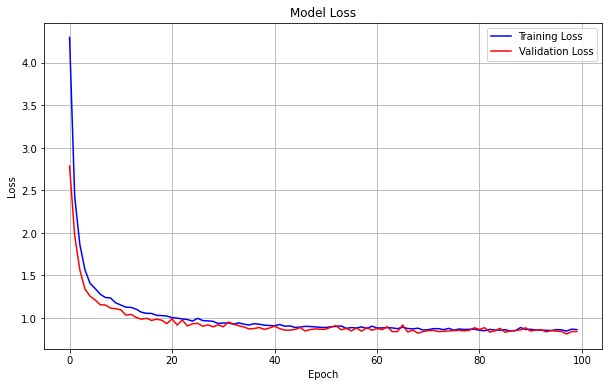

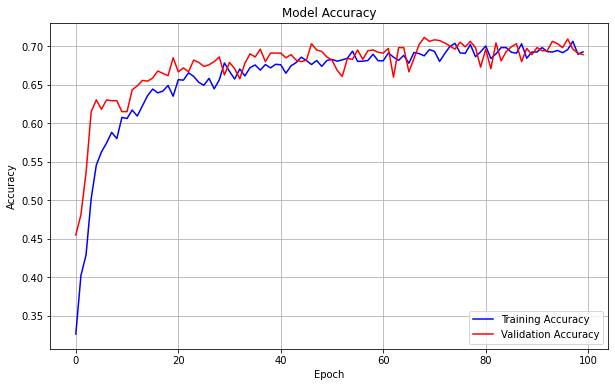

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'training_loss.png'))
plt.show()
# Draw the accuracy curve during training
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'training_accuracy.png'))
plt.show()


# Predict and calculate accuracy

## Prediction and Comparison:
- The trained model is loaded using `load_model` function to predict the classes for the test set (`X_test`).
- `y_test_classes`: The true class labels for the test set are adjusted based on the minimum label (`min_label`).
- `y_pred_classes`: The predicted class labels for the test set are obtained by selecting the class with the highest probability from the model's output.
  
## Accuracy Calculation:
- The accuracy of the predictions is computed using `accuracy_score` between the true and predicted class labels.

## Evaluation Metrics:
- **Mean Squared Error (MSE)**: Measures the average of the squared differences between true and predicted values.
- **R² Score**: A statistical measure of how well the predicted values approximate the true values. The closer to 1, the better the model.
- These metrics are printed and logged for further analysis.

## Save Predictions:
- The predicted class labels (`y_pred_classes`) are saved in a CSV file (`predictions.csv`) for later analysis.

## Confusion Matrix:
- A confusion matrix is generated using `confusion_matrix` to visually assess the performance of the classification model.
- The matrix is plotted using a heatmap, showing the true versus predicted values.

## Classification Report:
- A detailed classification report (`classification_report`) is generated to evaluate the precision, recall, f1-score, and support for each class.
- This report is saved as `classification_report.txt` for documentation purposes.

## Plot True vs Predicted Values:
- A plot is generated to compare the true values (`y_test_classes`) and predicted values (`y_pred_classes`) over the samples in the test set.
- The plot is saved as `true_vs_predicted.png`.

## Output Files:
- Predictions: `predictions.csv`
- Confusion Matrix: `confusion_matrix.png`
- Classification Report: `classification_report.txt`
- True vs Predicted Plot: `true_vs_predicted.png`


3.0
16/16 [==============================] - 0s 4ms/step


Test MSE: 0.449393
Test R² Score: 0.948191
Test MAE: 0.360324


Test MSE: 0.449393
Test R² Score: 0.948191
Test MAE: 0.360324


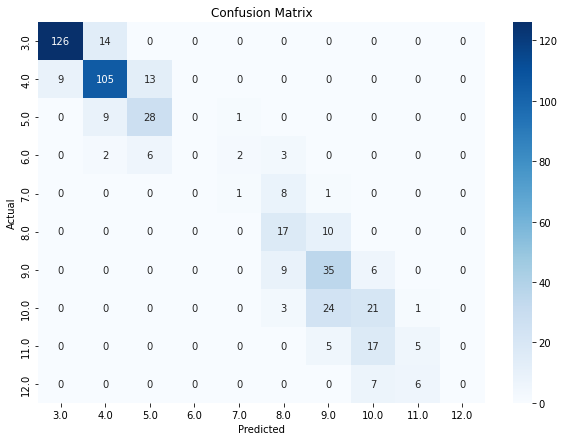

/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

         3.0       0.93      0.90      0.92       140
         4.0       0.81      0.83      0.82       127
         5.0       0.60      0.74      0.66        38
         6.0       0.00      0.00      0.00        13
         7.0       0.25      0.10      0.14        10
         8.0       0.42      0.63      0.51        27
         9.0       0.47      0.70      0.56        50
        10.0       0.41      0.43      0.42        49
        11.0       0.42      0.19      0.26        27
        12.0       0.00      0.00      0.00        13

    accuracy                           0.68       494
   macro avg       0.43      0.45      0.43       494
weighted avg       0.66      0.68      0.66       494



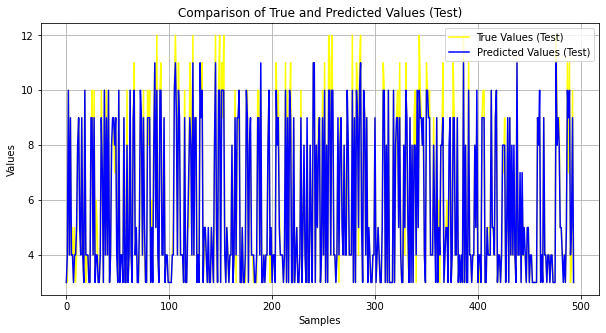

In [7]:
print(min_label)
# Predict and calculate accuracy
model = load_model(model_file)
y_test_classes = np.argmax(y_test, axis=1) + min_label 
y_pred = model.predict(X_test)
y_pred_classes  = np.argmax(y_pred, axis=1) + min_label   
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
# Calculate and print Mean Squared Error (MSE) and R² score
mse = mean_squared_error(y_test_classes, y_pred_classes)
r2 = r2_score(y_test_classes, y_pred_classes)
mae = mean_absolute_error(y_test_classes, y_pred_classes)
print(f"Test MSE: {mse:.6f}")
print(f"Test R² Score: {r2:.6f}")
print(f"Test MAE: {mae:.6f}")
logging.info(f"Test MSE: {mse:.6f}")
logging.info(f"Test R² Score: {r2:.6f}")
logging.info(f"Test MAE: {mae:.6f}")
#print(f"Test accuracy: {test_accuracy:.6f}")
#logging.info(f"Test accuracy: {test_accuracy:.6f}")
#print(f'Test Accuracy: {accuracy * 100:.2f}%')
# Save predictions
np.savetxt(os.path.join(dir_output, 'predictions.csv'), y_pred_classes, delimiter=',', fmt='%d')

comparison = np.stack((y_test_classes, y_pred_classes), axis=-1)
np.savetxt(os.path.join(dir_output, 'true_vs_predicted_classification.csv'), comparison, delimiter=',', fmt='%d', header='True,Predicted')
#test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
#print(f"Test accuracy: {test_accuracy:.6f}")
cm = confusion_matrix(y_test_classes, y_pred_classes)
labels = np.arange(min_label, min_label + cm.shape[0])
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(dir_output, 'confusion_matrix.png'))
plt.show()
# print the report of prediction
report = classification_report(y_test_classes, y_pred_classes)
print(report)
report_path = os.path.join(dir_output, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write(report)
plt.figure(figsize=(10, 5))
plt.plot(y_test_classes, label='True Values (Test)', color='yellow', linewidth=1.5)
plt.plot(y_pred_classes, label='Predicted Values (Test)', color='blue', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Comparison of True and Predicted Values (Test)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'true_vs_predicted.png'))
plt.show()
